In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [61]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0
2016-05-14 04:02:52+00:00,-33.415104,151.221976,208.6,29.0,0.0,62.0,109.0,0.007111,0.0,25.599979,1.0


# Data Analysis

### Remove NaN rows from dataframes

In [74]:
rr_2016.dropna(inplace=True)
rr_2019.dropna(inplace=True)
tt_2016.dropna(inplace=True)
tt_2019.dropna(inplace=True)

### Overall Distance Travelled

In [75]:
print("Road Races 2016 Total Distance:", round(rr_2016.distance.sum(), 2))
print("Time Trials 2016 Total Distance:", round(tt_2016.distance.sum(), 2))
print("Road Races 2019 Total Distance:", round(rr_2019.distance.sum(), 2))
print("Time Trials 2019 Total Distance:", round(tt_2019.distance.sum(), 2))

Road Races 2016 Total Distance: 49.05
Time Trials 2016 Total Distance: 24.8
Road Races 2019 Total Distance: 51.79
Time Trials 2019 Total Distance: 24.38


Road races are longer compared to time trials. The longest race was the road race in 2019.

### Range of Speeds

In [76]:
print("Range of Road Race Speed in 2016:", round(rr_2016.speed.max() - rr_2016.speed.min(), 2))
print("Range of Time Trials Speed in 2016:", round(tt_2016.speed.max() - tt_2016.speed.min(), 2))
print("Range of Road Race Speed in 2019:", round(rr_2019.speed.max() - rr_2019.speed.min(), 2))
print("Range of Time Trials Speed in 2019:", round(tt_2019.speed.max() - tt_2019.speed.min(), 2))

Range of Road Race Speed in 2016: 92.75
Range of Time Trials Speed in 2016: 162.51
Range of Road Race Speed in 2019: 63.63
Range of Time Trials Speed in 2019: 56.43


### Time Trial Differences - 2016 vs 2019

In [77]:
print("Average speed of Time Trial in 2016:", round(tt_2016.speed.mean(), 2))
print("Average speed of Time Trial in 2019:", round(tt_2019.speed.mean(), 2))

Average speed of Time Trial in 2016: 33.55
Average speed of Time Trial in 2019: 33.07


Fastest speed was the time trial of 2016

## Average speeds based on different elevations

### Road Race 2016

In [78]:
flat = (rr_2016['elevation_gain'] > -0.5) & (rr_2016['elevation_gain'] < 0.5)
decline = rr_2016['elevation_gain'] < -0.5
incline = rr_2016['elevation_gain'] > 0.5

print("Flat Mean: ", round(rr_2016.loc[flat, 'speed'].mean(), 2))
print("Decline Mean: ", round(rr_2016.loc[decline, 'speed'].mean(), 2))
print("Incline Mean: ", round(rr_2016.loc[incline, 'speed'].mean(), 2))

Flat Mean:  32.85
Decline Mean:  49.83
Incline Mean:  26.67


### Time Trial 2016

In [79]:
flat = (tt_2016['elevation_gain'] > -0.5) & (tt_2016['elevation_gain'] < 0.5)
decline = tt_2016['elevation_gain'] < -0.5
incline = tt_2016['elevation_gain'] > 0.5

print("Flat Mean: ", round(tt_2016.loc[flat, 'speed'].mean(), 2))
print("Decline Mean: ", round(tt_2016.loc[decline, 'speed'].mean(), 2))
print("Incline Mean: ", round(tt_2016.loc[incline, 'speed'].mean(), 2))

Flat Mean:  31.56
Decline Mean:  47.43
Incline Mean:  24.76


### Road Race 2019

In [80]:
flat = (rr_2019['elevation_gain'] > -0.5) & (rr_2019['elevation_gain'] < 0.5)
decline = rr_2019['elevation_gain'] < -0.5
incline = rr_2019['elevation_gain'] > 0.5

print("Flat Mean: ", round(rr_2019.loc[flat, 'speed'].mean(), 2))
print("Decline Mean: ", round(rr_2019.loc[decline, 'speed'].mean(), 2))
print("Incline Mean: ", round(rr_2019.loc[incline, 'speed'].mean(), 2))

Flat Mean:  32.63
Decline Mean:  50.34
Incline Mean:  29.94


### Time Trial 2019

In [81]:
flat = (tt_2019['elevation_gain'] > -0.5) & (tt_2019['elevation_gain'] < 0.5)
decline = tt_2019['elevation_gain'] < -0.5
incline = tt_2019['elevation_gain'] > 0.5

print("Flat Mean: ", round(tt_2019.loc[flat, 'speed'].mean(), 2))
print("Decline Mean: ", round(tt_2019.loc[decline, 'speed'].mean(), 2))
print("Incline Mean: ", round(tt_2019.loc[incline, 'speed'].mean(), 2))

Flat Mean:  31.93
Decline Mean:  51.39
Incline Mean:  29.39


## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





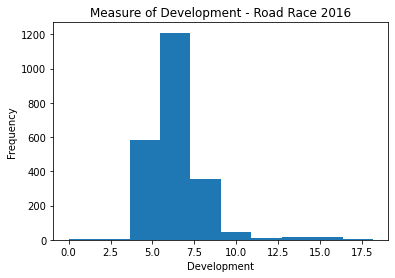

In [82]:
meters_second = rr_2016.speed / 3.6
cadence_second = rr_2016.cadence / 60
development =  meters_second / cadence_second

development.replace([np.inf, -np.inf], np.nan, inplace=True)
development = development[development<20]

ax = development.plot(kind='hist',title='Measure of Development - Road Race 2016')
ax.set(xlabel="Development", ylabel="Frequency")

plt.show()

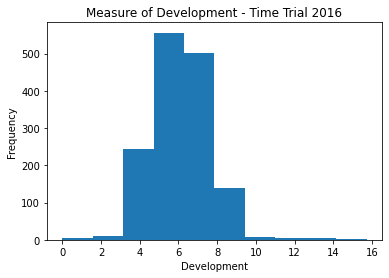

In [83]:
meters_second = tt_2016.speed / 3.6
cadence_second = tt_2016.cadence / 60
development =  meters_second / cadence_second

development.replace([np.inf, -np.inf], np.nan, inplace=True)
development = development[development<20]

ax = development.plot(kind='hist',title='Measure of Development - Time Trial 2016')
ax.set(xlabel="Development", ylabel="Frequency")

plt.show()

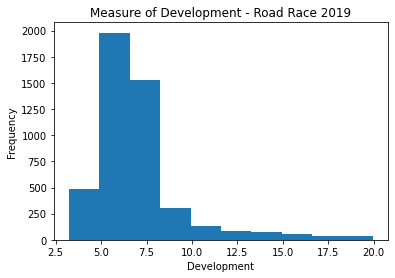

In [84]:
meters_second = rr_2019.speed / 3.6
cadence_second = rr_2019.cadence / 60
development =  meters_second / cadence_second

development.replace([np.inf, -np.inf], np.nan, inplace=True)
development = development[development<20]

ax = development.plot(kind='hist',title='Measure of Development - Road Race 2019')
ax.set(xlabel="Development", ylabel="Frequency")

plt.show()

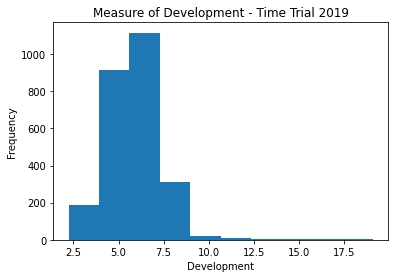

In [85]:
meters_second = tt_2019.speed / 3.6
cadence_second = tt_2019.cadence / 60
development =  meters_second / cadence_second

development.replace([np.inf, -np.inf], np.nan, inplace=True)
development = development[development<20]

ax = development.plot(kind='hist',title='Measure of Development - Time Trial 2019')
ax.set(xlabel="Development", ylabel="Frequency")

plt.show()

It can be noted from these histograms that the development used throughout time trials is lower compared to Road Races. This is  most likely due to the rider trying to obtain the fastest time possible throughout the time trial, but conserving energy throughout the road races.